# Connect HBASE

In [109]:
import happybase
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StructType, StructField, DoubleType

# HBase 연결 설정
connection = happybase.Connection('localhost', port=9090)
# 테이블 선택
table_name = 'NYC_MANHATTAN_SALES'
# 테이블 연결
table = connection.table(table_name)
uses = ["TOTAL UNITS", "YEAR BUILT", "SALE PRICE"]
# 사용할 컬럼 정리
schema = StructType([
    StructField("SALES:TOTAL UNITS", DoubleType(), True),
    StructField("SALES:SALE PRICE", DoubleType(), True),
    StructField("SALES:YEAR BUILT", IntegerType(), True),
])

# 데이터 스캔 및 Spark DataFrame 생성
rows = []
for key, data in table.scan():
    row = {'RowKey': key.decode('utf-8')}
    for column, value in data.items():
        if "SALES" in column.decode('utf-8'):
            column_name = f"{column.decode('utf-8')}"
            if uses[1] in column_name:
                row[column_name] = int(value.decode('utf-8').split('.')[0])
            else: row[column_name] = float(value.decode('utf-8'))
    rows.append(row)

# SparkSession 초기화
spark = SparkSession.builder.appName(table_name).getOrCreate()

# Spark DataFrame 생성
df = spark.createDataFrame(rows, schema)
df.show(truncate=False)

+-----------------+----------------+----------------+
|SALES:TOTAL UNITS|SALES:SALE PRICE|SALES:YEAR BUILT|
+-----------------+----------------+----------------+
|1.0              |399000.0        |1900            |
|10.0             |5650000.0       |1910            |
|0.0              |202500.0        |1900            |
|1.0              |120000.0        |2008            |
|1.0              |0.0             |1989            |
|1.0              |0.0             |1989            |
|1.0              |760000.0        |1989            |
|1.0              |1275000.0       |1989            |
|1.0              |580000.0        |1989            |
|1.0              |780000.0        |1989            |
|1.0              |1365000.0       |1989            |
|1.0              |805000.0        |1989            |
|1.0              |790000.0        |1989            |
|1.0              |895000.0        |1989            |
|1.0              |968000.0        |2011            |
|1.0              |900000.0 

In [110]:
df.printSchema()

root
 |-- SALES:TOTAL UNITS: double (nullable = true)
 |-- SALES:SALE PRICE: double (nullable = true)
 |-- SALES:YEAR BUILT: integer (nullable = true)



# SELECT DATAFRAME COLUMNS

In [141]:
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F

df = df.withColumn(
    "SALES:SALE PRICE", F.regexp_replace("SALES:SALE PRICE", "[$,]", "").cast(IntegerType())
)

selected_df = df.select(
    F.col("SALES:SALE PRICE").alias("SALES"),
    F.col("SALES:TOTAL UNITS").alias("UNITS"),
    F.col("SALES:YEAR BUILT").alias("YEAR"),
).where(
    '`SALES:SALE PRICE` > 0 and `SALES:TOTAL UNITS` > 0 and `SALES:YEAR BUILT` > 0'
)

In [142]:
display(selected_df)

DataFrame[SALES: int, UNITS: double, YEAR: int]

# Create Year Range and Avg Price

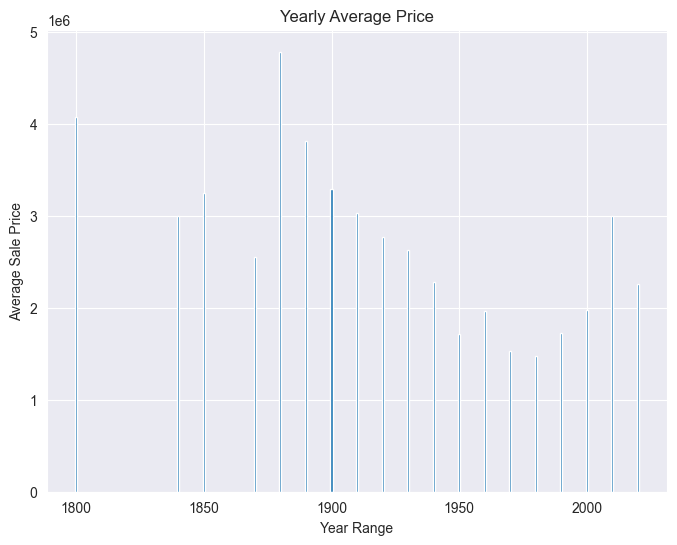

In [145]:
from pyspark.sql.functions import expr
from matplotlib import pyplot as plt

# 연도 범위 생성
sDf = selected_df.withColumn("YEAR_RANGE", expr("CAST((YEAR DIV 10) * 10 AS INT)"))  # 10년 단위로 범주화 예시

# 연도 범위에 따른 판매 가격 평균 계산
grouped_df = sDf.groupBy("YEAR_RANGE").agg(F.avg("SALES").alias("AVG_PRICE"))

# Pandas DataFrame 으로 변환
pandas_df = grouped_df.toPandas()

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(pandas_df["YEAR_RANGE"], pandas_df["AVG_PRICE"])
plt.title("Yearly Average Price")
plt.xlabel("Year Range")
plt.ylabel("Average Sale Price")
plt.show()


# Pearson Correlation Coefficient

In [148]:
correlation = selected_df.corr("SALES", "YEAR")
print(correlation)

-0.10865602342684672


# Shut down the connection

In [149]:
# SparkSession 종료
spark.stop()

# HBase 연결 닫기
connection.close()